### RQ4. Transfer Scores to Proprietary Models

In [1]:
import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm

from analysis_utils import get_test_results_all_tasks, target_testsuites, load_input_hidden_states

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import torch
import random

import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scienceplots

plt.style.use(["science", "grid", "nature"])

gpt_4o_mini_result_path = '../clotho/results_gpt4o_mini'
claude_result_path = '../clotho/results_claude-3-5-haiku-20241022'
gemini_result_path = '../clotho/results_gemini-2.5-flash-lite'

In [5]:
import json
import random
from analysis_utils import get_test_results, target_testsuites

target_tasks = list(target_testsuites.keys())
source_llms = ['gemma', 'llama', 'mistral']
target_llms = ['gpt4o_mini', 'claude-3-5-haiku-20241022', 'gemini-2.5-flash-lite']

with open('rq4_dataset_random_indices.json') as f:
    dataset_random_indices = json.load(f)

inference_results = {}
test_scores = {}

for model in target_llms:
    inference_results[model] = {}
    test_scores[model] = {}
    for task in tqdm(target_tasks, desc=f'Processing model: {model}'):
        _inference_results, _, _test_scores = get_test_results(model, task)
        inference_results[model][task] = []
        test_scores[model][task] = []
        
        for i, data in enumerate(_inference_results):
            if data['input_index'] in dataset_random_indices[task]:
                inference_results[model][task].append(data)
                test_scores[model][task].append(_test_scores[i])
                
        assert len(inference_results[model][task]) == len(dataset_random_indices[task]), f"Length mismatch for {model} on {task}: required {len(dataset_random_indices[task])}, got {len(inference_results[model][task])}"

MAX_NUM_TEST = 2000


Processing model: gemini-2.5-flash-lite: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


| model                     | task_name               |   num_test_cases |   avg_test_score |   all_correct_ratio |   any_correct_ratio |
|:--------------------------|:------------------------|-----------------:|-----------------:|--------------------:|--------------------:|
| gpt4o_mini                | syntactic_bug_detection |             2000 |          0.64015 |              0.5555 |              0.765  |
| gpt4o_mini                | spell_check             |             2000 |          0.8979  |              0.866  |              0.931  |
| gpt4o_mini                | github_typo_check       |             2000 |          0.69855 |              0.6175 |              0.7525 |
| gpt4o_mini                | json_repair             |             2000 |          0.9653  |              0.9385 |              0.9735 |
| gpt4o_mini                | pos_detection           |             2000 |          0.83185 |              0.753  |              0.907  |
| gpt4o_mini                | topi

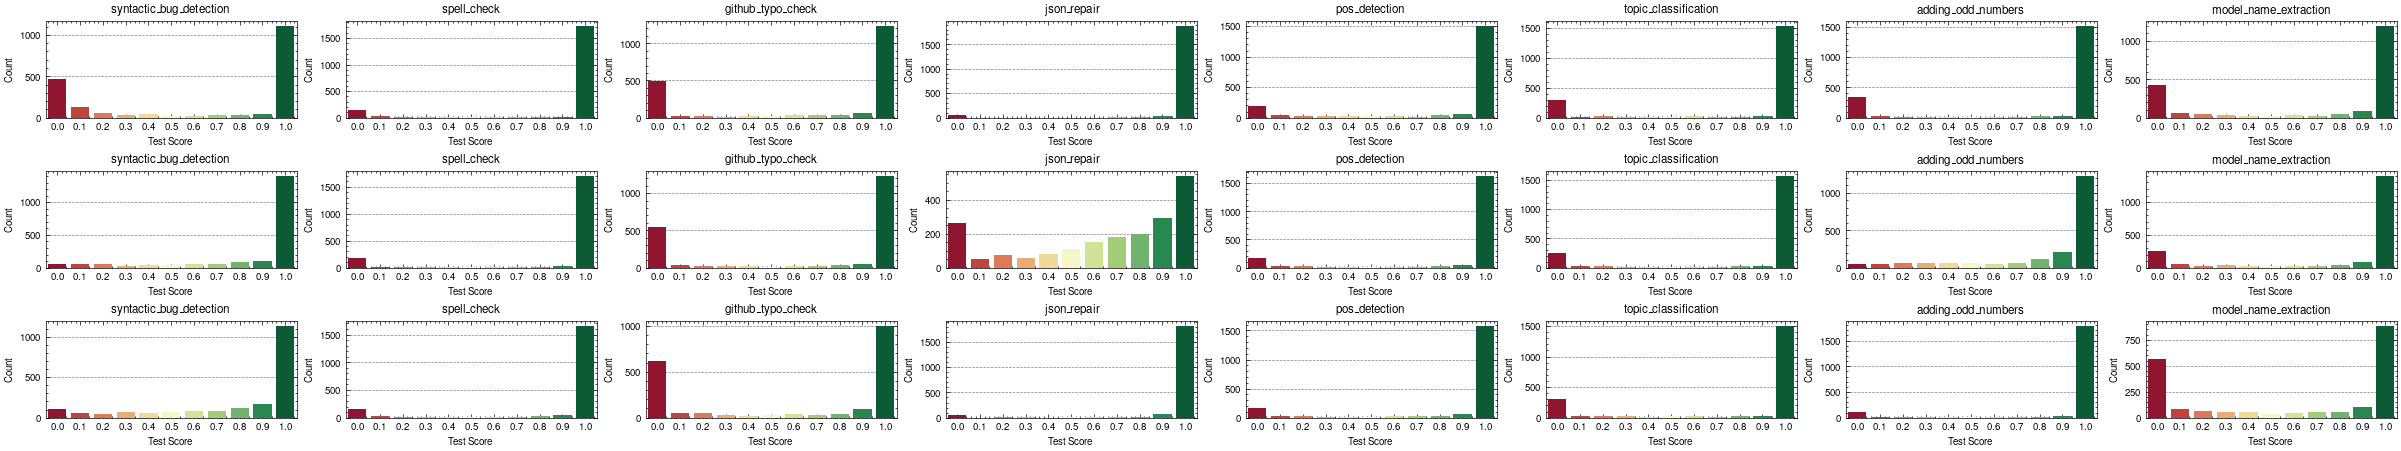

In [6]:
fig, axes = plt.subplots(len(target_llms), len(target_tasks), figsize=(3*(len(target_tasks)), 1.5*len(target_llms)), constrained_layout=True)

stat_rows = []

for model_idx, model in enumerate(target_llms):
    for idx, task_name in enumerate(target_tasks):
        if task_name not in test_scores[model]:
            print(f"Task {task_name} not found in test_scores.")
            fig.delaxes(axes[model_idx, idx])
            continue

        scores = test_scores[model][task_name]
        value_counts = pd.Series(scores).value_counts().sort_index()
        stat_rows.append({
            'model': model,
            'task_name': task_name,
            'num_test_cases': len(scores),
            'avg_test_score': sum(scores) / len(scores),
            'all_correct_ratio': sum([1 for score in scores if score == 1.0]) / len(scores),
            'any_correct_ratio': sum([1 for score in scores if score > 0.0]) / len(scores)
        })

        sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, ax=axes[model_idx, idx], palette='RdYlGn', legend=False)
        axes[model_idx, idx].set_title(f'{task_name}')
        axes[model_idx, idx].set_xlabel('Test Score')
        axes[model_idx, idx].set_ylabel('Count')

print(pd.DataFrame(stat_rows).to_markdown(index=False))

fig.show()


### Correlation Coefficients when Transferred

In [ ]:
refset_sizes = [100, 200, 300, 400, 500]

model = 'llama'
target_layer_map = {
    'llama': 21,
    'gemma': 28,
    'mistral': 22
}

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

target_layer = target_layer_map[model]
NUM_INITIAL_TESTS = 10
NUM_RANDOM_SEEDS = 5

result_suffix = f"_{model}"
target_iterations = [size // 10 for size in refset_sizes]

def load_individual_run_result(task, target_method, seed, num_reference, target_llm='llama', omit_initial_tests=True):
    result_suffix = f"_{target_llm}"
    target_layer = target_layer_map[target_llm]
    
    task_result_df = pd.read_pickle('../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, target_layer, seed, target_method))
    target_iteration_df = task_result_df[task_result_df['iteration'] == num_reference // 10].copy()
    
    if omit_initial_tests:
        target_indices = sorted(target_iteration_df.input_index.tolist())[:-NUM_INITIAL_TESTS]
        target_iteration_df_noref = target_iteration_df[target_iteration_df['input_index'].isin(target_indices)]
        return target_iteration_df_noref
    else:
        return target_iteration_df
    

olm_dfs = {}    

for model in source_llms:
    for task in target_tasks:
        for seed in range(10):
            df = load_individual_run_result(task, 'balanced', seed, 500, model)
            df = df[df.input_index.isin(dataset_random_indices[task])].sort_values('input_index')
            olm_dfs[(model, task, seed)] = df


In [13]:
from analysis_utils import calculate_pearson_correlation
from scipy.stats import spearmanr
import numpy as np

transfer_result_rows = []

for olm in source_llms:
    for clm in target_llms:
        for i, task in enumerate(target_tasks):
            corr, _ = spearmanr(olm_dfs[(olm, task, 0)].test_score, test_scores[clm][task])

            failing_indices_olm = set(
                np.where(olm_dfs[(olm, task, 0)].test_score.to_numpy() < 0.5)[0]
            )

            failing_indices_closed_llm = set(
                np.where(np.array(test_scores[clm][task]) < 0.5)[0]
            )

            overlap = failing_indices_olm & failing_indices_closed_llm

            for s in range(10):
                corr_pred_self, _ = spearmanr(olm_dfs[(olm, task, s)].logprob_rank, olm_dfs[(olm, task, s)].test_score)

                corr_pred_transfer, _ = spearmanr(olm_dfs[(olm, task, s)].logprob_rank, test_scores[clm][task])
                
                transfer_result_rows.append({
                    'source_model': olm,
                    'target_model': clm,
                    'task': task,
                    'seed': s,
                    'corr_pred_self': corr_pred_self,
                    'corr_pred_transfer': corr_pred_transfer,
                    'corr_test_scores': corr,
                    'source_failure_rate': len(failing_indices_olm) / len(olm_dfs[(olm, task, s)]),
                    'target_failure_rate': len(failing_indices_closed_llm) / len(test_scores[clm][task]),
                    'source_failure_count': len(failing_indices_olm),
                    'target_failure_count': len(failing_indices_closed_llm),
                    'overlap_failure_count': len(overlap),
                    'ratio_failed_also_in_target': len(overlap) / len(failing_indices_olm),
                    'ratio_failed_also_in_olm': len(overlap) / len(failing_indices_closed_llm),
                    'ratio_failed_only_in_target': len(failing_indices_closed_llm - failing_indices_olm) / len(failing_indices_closed_llm),
                    'ratio_failed_only_in_olm': len(failing_indices_olm - failing_indices_closed_llm) / len(failing_indices_olm),
                })

    corr_df = pd.DataFrame(transfer_result_rows)

In [14]:
def mean_std(x):
    return f"{x.mean():.3f} ± {x.std():.2f}"

model_name_converter = {
    'gpt4o_mini': 'GPT',
    'claude-3-5-haiku-20241022': 'Claude',
    'gemini-2.5-flash-lite': 'Gemini'
}

df = corr_df.copy()
df['target_model'] = df['target_model'].map(model_name_converter)
df = df[df.source_model.isin(['llama', 'gemma', 'mistral'])]

df_grouped = (
    df.groupby(['task', 'target_model', 'source_model'])
      .agg({
          'corr_pred_self': 'mean',
          'corr_pred_transfer': 'mean',
      })
).reset_index().pivot(index=['task'], columns=['source_model', 'target_model'], values=['corr_pred_self', 'corr_pred_transfer'])

df_grouped = df_grouped.swaplevel(0,1,axis=1).sort_index(axis=1, level=0)

corr_self = df_grouped.xs('corr_pred_self', axis=1, level=1)
corr_self_merged = corr_self.groupby(level=0, axis=1).mean()

df_tmp = df_grouped.drop(columns='corr_pred_self', level=1)

for src in corr_self_merged.columns:
    df_tmp[(src, 'corr_pred_self', 'merged')] = corr_self_merged[src]

df_final = df_tmp.copy()
df_final.columns = df_final.columns.droplevel(1)
df_final = df_final.sort_index(axis=1, level=0)

new_cols = []
for src in df_final.columns.levels[0]:
    targets = list(df_final[src].columns)
    if 'merged' in targets:
        targets = ['merged'] + [t for t in targets if t != 'merged']
    new_cols.extend([(src, t) for t in targets])

df_final = df_final[new_cols]

df_final = df_final.rename(index=task_alias_map)

df_final.round(3)


source_model  gemma                       llama                      mistral  \
target_model merged Claude    GPT Gemini merged Claude    GPT Gemini  merged   
task                                                                           
ODD-ADD       0.444  0.447  0.094  0.064  0.549  0.411  0.439  0.235   0.434   
GH-TYPO       0.438  0.383  0.373  0.442  0.470  0.380  0.365  0.413   0.197   
JSON-FIX      0.394  0.128  0.108  0.111  0.360  0.098  0.167  0.160   0.568   
MODEL-EX      0.386  0.248  0.347  0.402  0.512  0.248  0.341  0.427   0.555   
POS-TAG       0.289  0.267  0.272  0.253  0.221  0.210  0.235  0.184   0.138   
SPELL-CHK     0.452  0.465  0.443  0.419  0.374  0.349  0.340  0.321   0.247   
SYN-BUG       0.707  0.435  0.543  0.532  0.345  0.190  0.178  0.224   0.396   
TOPIC-CLS     0.252  0.215  0.259  0.229  0.256  0.188  0.201  0.209   0.181   

source_model                       
target_model Claude    GPT Gemini  
task                               
ODD-ADD       0.231  0.437  0.182  
GH-TYPO       0.106  0.140  0.125  
JSON-FIX      0.203 -0.010  0.006  
MODEL-EX      0.288  0.380  0.456  
POS-TAG       0.190  0.233  0.173  
SPELL-CHK     0.292  0.263  0.239  
SYN-BUG       0.325  0.379  0.349  
TOPIC-CLS     0.139  0.160  0.161

In [10]:
print(df_final.applymap(lambda x: f"{x:.3f}").to_latex())

\begin{tabular}{lllllllllllll}
\toprule
source_model & \multicolumn{4}{r}{gemma} & \multicolumn{4}{r}{llama} & \multicolumn{4}{r}{mistral} \\
target_model & merged & Claude & GPT & Gemini & merged & Claude & GPT & Gemini & merged & Claude & GPT & Gemini \\
task &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
ODD-ADD & 0.444 & 0.447 & 0.094 & 0.064 & 0.549 & 0.411 & 0.439 & 0.235 & 0.434 & 0.231 & 0.437 & 0.182 \\
GH-TYPO & 0.438 & 0.383 & 0.373 & 0.442 & 0.470 & 0.380 & 0.365 & 0.413 & 0.197 & 0.106 & 0.140 & 0.125 \\
JSON-FIX & 0.394 & 0.128 & 0.108 & 0.111 & 0.360 & 0.098 & 0.167 & 0.160 & 0.568 & 0.203 & -0.010 & 0.006 \\
MODEL-EX & 0.386 & 0.248 & 0.347 & 0.402 & 0.512 & 0.248 & 0.341 & 0.427 & 0.555 & 0.288 & 0.380 & 0.456 \\
POS-TAG & 0.289 & 0.267 & 0.272 & 0.253 & 0.221 & 0.210 & 0.235 & 0.184 & 0.138 & 0.190 & 0.233 & 0.173 \\
SPELL-CHK & 0.452 & 0.465 & 0.443 & 0.419 & 0.374 & 0.349 & 0.340 & 0.321 & 0.247 & 0.292 & 0.263 & 0.239 \\
SYN-BUG & 0.707 & 0.435 & 0.543 & 0.532 & 0

### Failure@N Using Tranferred Scores

In [15]:
def calculate_APFDc(scores, observed_correct_probs):
    scores = np.asarray(scores, dtype=float)
    p = np.clip(np.asarray(observed_correct_probs, dtype=float), 0.0, 1.0)
    assert scores.shape == p.shape

    order = np.argsort(scores)
    p_sorted = p[order]

    f = 1.0 - p_sorted

    N = len(f)
    W = f.sum()

    if N == 0:
        return np.nan
    if W <= 0:
        return 1.0

    positions = np.arange(1, N + 1, dtype=float)

    apfdc = 1.0 - (np.dot(f, positions) / (N * W)) + (1.0 / (2.0 * N))
    return float(apfdc)


def simulate_test_prioritization(pred_df, GT_scores, source_llm, target_llm, task, seed=0):
    apfd_graph_rows = []
            
    pred_scores = pred_df['logprob_rank'].to_numpy()
    GT_scores = np.array(GT_scores)
            
    failures_continuous = 1.0 - GT_scores
    failures_discrete_majority = (failures_continuous > 0.5).astype(int)
    failures = failures_discrete_majority
                
    APFD = calculate_APFDc(pred_scores, 1 - failures)

    failures_sum = np.sum(failures)
    assert failures_sum > 0, "No failures found in the dataset."
            
    order = np.argsort(pred_scores)

    failures_cumulative = 0
    for exec_index, i in enumerate(order):
        weight_new_failures = failures[i]
        failures_cumulative += weight_new_failures
        apfd_graph_rows.append({
            'execution_index': exec_index,
            'source_llm': source_llm,
            'target_llm': model_name_converter[target_llm],
            'task': task,
            'pred_score': pred_scores[i],
            'actual_score': GT_scores[i],
            'failure_cumulative': failures_cumulative,
            'failure_percent': failures_cumulative / failures_sum,
            'APFD': APFD,
            'sort_method': 'Clotho',
            'seed': seed
        })

    # random order
    np.random.seed(seed)
    failures_cumulative = 0
    random_order = np.random.permutation(len(pred_scores))
    for exec_index, i in enumerate(random_order):
        weight_new_failures = failures[i]
        failures_cumulative += weight_new_failures
        apfd_graph_rows.append({
            'execution_index': exec_index,
            'source_llm': source_llm,
            'target_llm': model_name_converter[target_llm],
            'task': task,
            'pred_score': pred_scores[i],
            'actual_score': GT_scores[i],
            'failure_cumulative': failures_cumulative,
            'failure_percent': failures_cumulative / failures_sum,
            'sort_method': 'random',
            'seed': seed
        })
    
        
    return pd.DataFrame(apfd_graph_rows)


simulate_test_prioritization(olm_dfs[('llama','adding_odd_numbers', 0)], test_scores_selected['gpt4o_mini']['adding_odd_numbers'], 'llama', 'gpt4o_mini', 'adding_odd_numbers', seed=0)

,execution_index,source_llm,target_llm,task,pred_score,actual_score,failure_cumulative,failure_percent,APFD,sort_method,seed
0,0,llama,GPT,adding_odd_numbers,0.000499,0.0,1,0.002427,0.724708,Clotho,0
1,1,llama,GPT,adding_odd_numbers,0.001331,0.0,2,0.004854,0.724708,Clotho,0
2,2,llama,GPT,adding_odd_numbers,0.001831,0.0,3,0.007282,0.724708,Clotho,0
3,3,llama,GPT,adding_odd_numbers,0.002330,0.0,4,0.009709,0.724708,Clotho,0
4,4,llama,GPT,adding_odd_numbers,0.002496,0.0,5,0.012136,0.724708,Clotho,0
...,...,...,...,...,...,...,...,...,...,...,...
3995,1995,llama,GPT,adding_odd_numbers,0.899484,1.0,412,1.000000,NaN,random,0
3996,1996,llama,GPT,adding_odd_numbers,0.987186,1.0,412,1.000000,NaN,random,0
3997,1997,llama,GPT,adding_odd_numbers,0.178233,1.0,412,1.000000,NaN,random,0
3998,1998,llama,GPT,adding_odd_numbers,0.157098,1.0,412,1.000000,NaN,random,0


Processing tasks: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


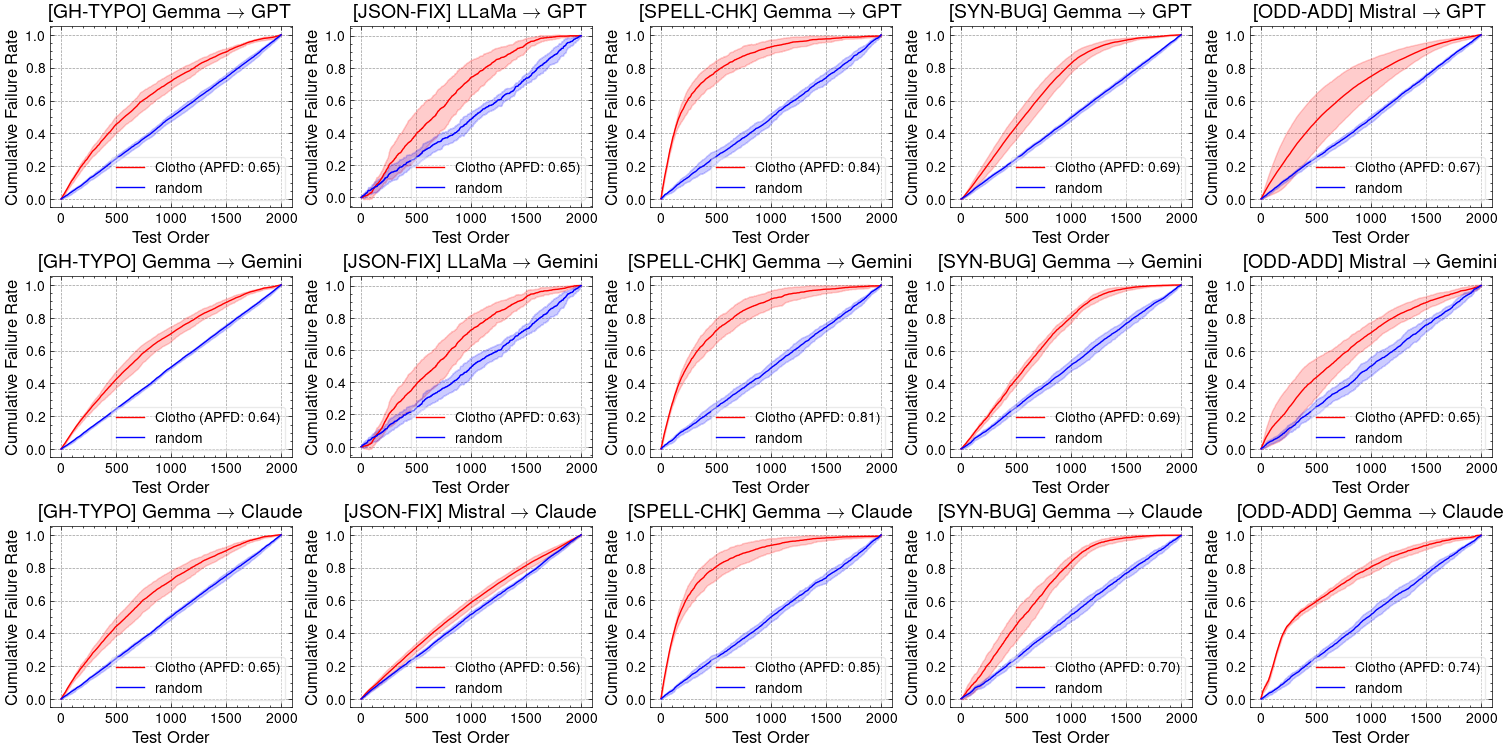

In [17]:
def capitalize(name):
    if name == 'gemma':
        return 'Gemma'
    elif name == 'llama':
        return 'LLaMa'
    elif name == 'qwen':
        return 'Qwen'
    elif name == 'mistral':
        return 'Mistral'
    else:
        return name.capitalize()
    
    
target_tasks_vis = ['github_typo_check', 'json_repair', 'spell_check', 'syntactic_bug_detection', 'adding_odd_numbers']
target_llms_vis = ['gpt4o_mini', 'gemini-2.5-flash-lite', 'claude-3-5-haiku-20241022']

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

fig, axes = plt.subplots(len(target_llms_vis), len(target_tasks_vis), figsize=(3 * len(target_tasks_vis), 2.5 * len(target_llms_vis)), sharex=False, sharey=False, constrained_layout=True)

for i, target_llm in enumerate(target_llms_vis):
    for j, task in enumerate(tqdm(target_tasks_vis, desc='Processing tasks')):
        all_dfs = []
        
        best_source_llm = None
        best_apfd = -1
        best_df = None
        for source_llm in source_llms:
            for seed in range(10):
                df = simulate_test_prioritization(olm_dfs[(source_llm, task, seed)], test_scores_selected[target_llm][task], source_llm, target_llm, task, seed=seed)

                all_dfs.append(df)
            df = pd.concat(all_dfs, ignore_index=True)
            
            APFD = df[df['sort_method'] == 'Clotho']['APFD'].mean()
            if APFD > best_apfd:
                best_apfd = APFD
                best_source_llm = source_llm
                best_df = df

        sns.lineplot(data=best_df[best_df['sort_method'] == 'Clotho'], x='execution_index', y='failure_percent',
                    label=f'Clotho (APFD: {best_apfd:.2f})', color='red', errorbar='sd', ax=axes[i, j], err_kws={'alpha': 0.2})
        sns.lineplot(data=best_df[best_df['sort_method'] == 'random'], x='execution_index', y='failure_percent',
                    label='random', color='blue', errorbar='sd', ax=axes[i, j], err_kws={'alpha': 0.2})

        axes[i, j].set_xlabel('Test Order')
        axes[i, j].set_ylabel('Cumulative Failure Rate')
        axes[i, j].set_title(f'[{task_alias_map[task]}] {capitalize(best_source_llm)} $\\rightarrow$ {model_name_converter[target_llm]}')
        axes[i, j].grid(alpha=0.4)
        axes[i, j].legend(frameon=True, framealpha=0.4, loc='lower right')

os.makedirs('figures/rq4', exist_ok=True)
fig.savefig(f'figures/rq4/apfd_graph_proprietary_best.png')
fig.savefig(f'figures/rq4/apfd_graph_proprietary_best.pdf', dpi=300)

In [18]:
all_dfs = []

for source_llm in source_llms:
    for target_llm in target_llms:
        for task in tqdm(target_tasks, desc='Processing tasks: ({}, {})'.format(source_llm, target_llm)):
            for seed in range(10):
                df = simulate_test_prioritization(olm_dfs[(source_llm, task, seed)], test_scores_selected[target_llm][task], source_llm, target_llm, task, seed=seed)
                all_dfs.append(df)

result_df = pd.concat(all_dfs, ignore_index=True)

Processing tasks: (gemma, gpt4o_mini): 100%|██████████| 8/8 [00:00<00:00, 11.55it/s]
Processing tasks: (gemma, claude-3-5-haiku-20241022): 100%|██████████| 8/8 [00:00<00:00, 11.69it/s]
Processing tasks: (llama, gpt4o_mini): 100%|██████████| 8/8 [00:00<00:00, 11.25it/s]
Processing tasks: (llama, claude-3-5-haiku-20241022): 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]
Processing tasks: (mistral, gpt4o_mini): 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]
Processing tasks: (mistral, claude-3-5-haiku-20241022): 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]
Processing tasks: (mistral, gemini-2.5-flash-lite): 100%|██████████| 8/8 [00:00<00:00, 11.40it/s]


In [19]:
result_df[result_df.execution_index.isin([100])].groupby(['sort_method'])['failure_cumulative'].mean()

sort_method
Clotho    42.472222
random    18.720833
Name: failure_cumulative, dtype: float64

In [20]:
cost_df = result_df[result_df.execution_index.isin([100, 300, 500])].groupby(['task', 'target_llm', 'source_llm', 'seed', 'execution_index', 'sort_method'])[[ 'failure_cumulative']].mean().reset_index()
# cost_df.loc[cost_df.sort_method == 'random', 'APFD'] = 0.5
cost_df_sum = cost_df[cost_df.execution_index.isin([100, 300, 500])].groupby(['target_llm', 'source_llm', 'execution_index', 'sort_method'])[['failure_cumulative']].mean().reset_index().pivot(index=['source_llm', 'execution_index'], columns=['target_llm', 'sort_method'])
cost_df_sum

failure_cumulative                              \
target_llm                             Claude                GPT            
sort_method                            Clotho   random    Clotho   random   
source_llm execution_index                                                  
gemma      100                        47.8500  18.2125   44.0250  19.7375   
           300                       115.0625  54.6375  112.0875  60.3000   
           500                       163.4250  90.6875  173.5250  99.6750   
llama      100                        40.3875  18.2125   45.8375  19.7375   
           300                        98.2875  54.6375  111.5500  60.3000   
           500                       147.1625  90.6875  164.6125  99.6750   
mistral    100                        37.6875  18.2125   45.9500  19.7375   
           300                        88.2500  54.6375  110.5125  60.3000   
           500                       133.1750  90.6875  165.4625  99.6750   

                                               
target_llm                    Gemini           
sort_method                   Clotho   random  
source_llm execution_index                     
gemma      100               42.2375  18.2125  
           300              106.6875  55.9375  
           500              161.8625  93.7375  
llama      100               40.7125  18.2125  
           300              102.0500  55.9375  
           500              153.0625  93.7375  
mistral    100               37.5625  18.2125  
           300               91.6875  55.9375  
           500              140.3250  93.7375

In [32]:
for N in [100, 500]:
    cost_df_sum = result_df[result_df.execution_index.isin([N])].groupby(['target_llm', 'execution_index', 'sort_method'])[['failure_cumulative']].mean().reset_index().pivot(index=['execution_index'], columns=['target_llm', 'sort_method'])
    display(cost_df_sum)

    print(cost_df_sum.sum())
    cost_sum = cost_df_sum.sum()

    print(cost_sum.sum(axis=0))

    claude_more_failures = cost_sum.failure_cumulative.Claude.Clotho - cost_sum.failure_cumulative.Claude.random
    gpt_more_failures = cost_sum.failure_cumulative.GPT.Clotho - cost_sum.failure_cumulative.GPT.random
    gemini_more_failures = cost_sum.failure_cumulative.Gemini.Clotho - cost_sum.failure_cumulative.Gemini.random

    claude_percentage = claude_more_failures / cost_sum.failure_cumulative.Claude.random * 100
    gpt_percentage = gpt_more_failures / cost_sum.failure_cumulative.GPT.random * 100
    gemini_percentage = gemini_more_failures / cost_sum.failure_cumulative.Gemini.random * 100

    print(f'# of additional failures found by Clotho over random at {N} tests: {claude_more_failures:.2f} (Claude)')
    print(f'# of additional failures found by Clotho over random at {N} tests: {gpt_more_failures:.2f} (GPT-4o-mini)')
    print(f'# of additional failures found by Clotho over random at {N} tests: {gemini_more_failures:.2f} (Gemini-2.5-flash-lite)')
    print(f'Average: {(claude_more_failures + gpt_more_failures + gemini_more_failures) / 3:.2f}')

    print(f'% of additional failures found by Clotho over random at {N} tests: {claude_percentage:.2f}% (Claude)')
    print(f'% of additional failures found by Clotho over random at {N} tests: {gpt_percentage:.2f}% (GPT-4o-mini)')
    print(f'% of additional failures found by Clotho over random at {N} tests: {gemini_percentage:.2f}% (Gemini-2.5-flash-lite)')
    print(f'Total Average: {(claude_percentage + gpt_percentage + gemini_percentage) / 3:.2f}%')

failure_cumulative                                          \
target_llm                  Claude                 GPT              Gemini   
sort_method                 Clotho   random     Clotho   random     Clotho   
execution_index                                                              
100                         41.975  18.2125  45.270833  19.7375  40.170833   

                          
target_llm                
sort_method       random  
execution_index           
100              18.2125

                    target_llm  sort_method
failure_cumulative  Claude      Clotho         41.975000
                                random         18.212500
                    GPT         Clotho         45.270833
                                random         19.737500
                    Gemini      Clotho         40.170833
                                random         18.212500
dtype: float64
183.57916666666668
# of additional failures found by Clotho over random at 100 tests: 23.76 (Claude)
# of additional failures found by Clotho over random at 100 tests: 25.53 (GPT-4o-mini)
# of additional failures found by Clotho over random at 100 tests: 21.96 (Gemini-2.5-flash-lite)
Average: 23.75
% of additional failures found by Clotho over random at 100 tests: 130.47% (Claude)
% of additional failures found by Clotho over random at 100 tests: 129.36% (GPT-4o-mini)
% of additional failures found by Clotho over random at 100 tests: 120.57% (Gemini-2.5-flash-lite)
Total Average: 126.80%


failure_cumulative                                       \
target_llm                  Claude                  GPT          Gemini   
sort_method                 Clotho   random      Clotho  random  Clotho   
execution_index                                                           
500                     147.920833  90.6875  167.866667  99.675  151.75   

                          
target_llm                
sort_method       random  
execution_index           
500              93.7375

                    target_llm  sort_method
failure_cumulative  Claude      Clotho         147.920833
                                random          90.687500
                    GPT         Clotho         167.866667
                                random          99.675000
                    Gemini      Clotho         151.750000
                                random          93.737500
dtype: float64
751.6375
# of additional failures found by Clotho over random at 500 tests: 57.23 (Claude)
# of additional failures found by Clotho over random at 500 tests: 68.19 (GPT-4o-mini)
# of additional failures found by Clotho over random at 500 tests: 58.01 (Gemini-2.5-flash-lite)
Average: 61.15
% of additional failures found by Clotho over random at 500 tests: 63.11% (Claude)
% of additional failures found by Clotho over random at 500 tests: 68.41% (GPT-4o-mini)
% of additional failures found by Clotho over random at 500 tests: 61.89% (Gemini-2.5-flash-lite)
Total Average: 64.47%


In [ ]:
df_fmt = cost_df_sum.copy()
df_fmt = df_fmt.round(2)

df_fmt = df_fmt.sort_index(axis=1, level=1)
df_fmt

failure_cumulative                                   
target_llm                  Claude           GPT        Gemini       
sort_method                 Clotho random Clotho random Clotho random
execution_index                                                      
100                          41.98  18.21  45.27  19.74  40.17  18.21

In [17]:
print(df_fmt.applymap(lambda x: f"{x:.2f}").to_latex())

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{6}{r}{failure_cumulative} \\
target_llm & \multicolumn{2}{r}{Claude} & \multicolumn{2}{r}{GPT} & \multicolumn{2}{r}{Gemini} \\
sort_method & Clotho & random & Clotho & random & Clotho & random \\
execution_index &  &  &  &  &  &  \\
\midrule
100 & 41.98 & 18.21 & 45.27 & 19.74 & 40.17 & 18.21 \\
\bottomrule
\end{tabular}



### Task-wise Breakdown (Failure@N)

In [29]:
cost_df = result_df[result_df.execution_index.isin([500])].groupby(['target_llm', 'source_llm', 'execution_index', 'sort_method', 'task'])[['failure_cumulative']].mean()
cost_df_sum = cost_df.reset_index().pivot(index=['task', 'execution_index'], columns=['target_llm', 'source_llm', 'sort_method'], values='failure_cumulative')

In [30]:
print(cost_df_sum.applymap(lambda x: f"{x:.1f}").to_latex())

\begin{tabular}{llllllllllllllllllll}
\toprule
 & target_llm & \multicolumn{6}{r}{Claude} & \multicolumn{6}{r}{GPT} & \multicolumn{6}{r}{Gemini} \\
 & source_llm & \multicolumn{2}{r}{gemma} & \multicolumn{2}{r}{llama} & \multicolumn{2}{r}{mistral} & \multicolumn{2}{r}{gemma} & \multicolumn{2}{r}{llama} & \multicolumn{2}{r}{mistral} & \multicolumn{2}{r}{gemma} & \multicolumn{2}{r}{llama} & \multicolumn{2}{r}{mistral} \\
 & sort_method & Clotho & random & Clotho & random & Clotho & random & Clotho & random & Clotho & random & Clotho & random & Clotho & random & Clotho & random & Clotho & random \\
task & execution_index &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
adding_odd_numbers & 500 & 165.5 & 69.9 & 123.7 & 69.9 & 79.8 & 69.9 & 103.4 & 103.3 & 242.1 & 103.3 & 241.5 & 103.3 & 42.1 & 37.8 & 78.0 & 37.8 & 72.2 & 37.8 \\
\cline{1-20}
github_typo_check & 500 & 280.3 & 156.2 & 284.0 & 156.2 & 201.0 & 156.2 & 260.3 & 140.4 & 246.3 & 140.4 & 184.5 & 140.4 & 329.6 & 189

In [ ]:
# Aggregated across all tasks

cost_df_sum = result_df[result_df.execution_index.isin([100, 300, 500])].groupby(['target_llm', 'source_llm', 'execution_index', 'sort_method'])[['failure_cumulative']].mean().reset_index().pivot(index=['source_llm', 'execution_index'], columns=['target_llm', 'sort_method'])
display(cost_df_sum)

failure_cumulative                              \
target_llm                             Claude                GPT            
sort_method                            Clotho   random    Clotho   random   
source_llm execution_index                                                  
gemma      100                        47.8500  18.2125   44.0250  19.7375   
           300                       115.0625  54.6375  112.0875  60.3000   
           500                       163.4250  90.6875  173.5250  99.6750   
llama      100                        40.3875  18.2125   45.8375  19.7375   
           300                        98.2875  54.6375  111.5500  60.3000   
           500                       147.1625  90.6875  164.6125  99.6750   
mistral    100                        37.6875  18.2125   45.9500  19.7375   
           300                        88.2500  54.6375  110.5125  60.3000   
           500                       133.1750  90.6875  165.4625  99.6750   

                                               
target_llm                    Gemini           
sort_method                   Clotho   random  
source_llm execution_index                     
gemma      100               42.2375  18.2125  
           300              106.6875  55.9375  
           500              161.8625  93.7375  
llama      100               40.7125  18.2125  
           300              102.0500  55.9375  
           500              153.0625  93.7375  
mistral    100               37.5625  18.2125  
           300               91.6875  55.9375  
           500              140.3250  93.7375